## This notebook is for plotting violin plots of the total sediment basket weights a GSD 

Importing the data:

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# load data
spring = pd.read_csv('spring2023_GSD.csv')
summer = pd.read_csv('summer2023_GSD.csv')

In [2]:
# Melt your DataFrame to long format
spring_melted = spring.melt(id_vars='Size', var_name='Sample', value_name='Percentage')
summer_melted = summer.melt(id_vars='Size', var_name='Sample', value_name='Percentage')
# Create a new DataFrame for total weights
spring_weights = spring[spring['Size'].isin(['WEIGHT'])].melt(id_vars='Size', var_name='Sample', value_name='Weight')
summer_weights = summer[summer['Size'].isin(['WEIGHT'])].melt(id_vars='Size', var_name='Sample', value_name='Weight')

Bar plot comparing different weights

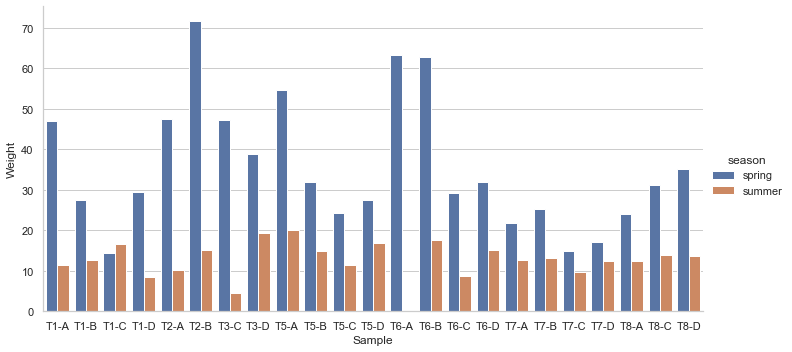

In [3]:
# Add a new column to indicate the season
spring_weights['season'] = 'spring'
summer_weights['season'] = 'summer'

# Concatenate the two dataframes
weights = pd.concat([spring_weights, summer_weights])

# Create the bar plot
sns.set_theme(style="whitegrid")
sns.catplot(data=weights, x='Sample', y='Weight', hue='season', kind='bar', height=5, aspect=2)

plt.show()

<AxesSubplot: xlabel='day', ylabel='total_bill'>

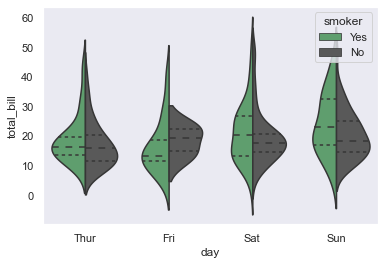

In [4]:
# testing how the violin plot works
sns.set_theme(style="dark")

# load the example tips dataset
tips = sns.load_dataset("tips")

# draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=tips, x="day", y="total_bill", hue="smoker",
            split=True, inner="quart", fill=False,
            palette={"Yes": "g", "No": ".35"})

Converting data for violin plots

In [25]:
# create count dataframes based off the percentages of the original dataframes
spring_counts = pd.DataFrame()
summer_counts = pd.DataFrame()
# make the first row the size values
spring_counts['Size'] = spring['Size'][:-2].astype(float) # excluded WEIGHT and TOTAL rows
summer_counts['Size'] = summer['Size'][:-2].astype(float)

# multiply all the column values by 1000 to get the counts
for basket in spring.columns:
    if basket != 'Size':
        spring_counts[basket] = spring[basket] * 1000
for basket in summer.columns:
    if basket != 'Size':
        summer_counts[basket] = summer[basket] * 1000

In [26]:
# define a regular grid of grain sizes
spring_regular = pd.DataFrame()
summer_regular = pd.DataFrame()
spring_regular['Size'] = np.linspace(spring_counts['Size'].min(), spring_counts['Size'].max(), 8000)
summer_regular['Size'] = np.linspace(summer_counts['Size'].min(), summer_counts['Size'].max(), 8000)

# interpolate the counts for the regularly sized bins
for basket in spring_counts.columns:
    if basket != 'Size':
        f = interp1d(spring_counts['Size'], spring_counts[basket], kind='linear')
        spring_regular[basket] = f(spring_regular['Size']).round()
for basket in summer_counts.columns:
    if basket != 'Size':
        f = interp1d(summer_counts['Size'], summer_counts[basket], kind='linear')
        summer_regular[basket] = f(summer_regular['Size']).round()

In [27]:
# create actual sample data from the regularly sized binned data
# spring
samples_spring = []

for basket in spring_regular.columns:
    if basket != 'Size':
        repeated_values = np.repeat(spring_regular['Size'], spring_regular[basket])
        basket_ids = [basket] * len(repeated_values)
        df = pd.DataFrame({
            'value': repeated_values,
            'basket_id': basket_ids,
            'season': 'spring'
        })
        samples_spring.append(df)

# summer
samples_summer = []

for basket in summer_regular.columns:
    if basket != 'Size':
        repeated_values = np.repeat(summer_regular['Size'], summer_regular[basket])
        basket_ids = [basket] * len(repeated_values)
        df = pd.DataFrame({
            'value': repeated_values,
            'basket_id': basket_ids,
            'season': 'summer'
        })
        samples_summer.append(df)

# concatenate the two lists of dataframes
samples = pd.concat(samples_spring + samples_summer, ignore_index=True)

In [5]:
# get spring data
num_points = 1000
samples = []

for basket in spring.columns:
    if basket != 'Size':
        spring[basket+'_quantity'] = spring[basket] * num_points
        repeated_values = np.repeat(spring['Size'][:-2], spring[basket+'_quantity'][:-2])
        basket_ids = [basket] * len(repeated_values)
        samples.append(pd.DataFrame({
            'value': repeated_values,
            'basket_id': basket_ids
        }))

# concatenate all the df in the list into a single spring dataframe
samples_spring = pd.concat(samples, ignore_index=True)
samples_spring['season'] = 'spring' 

# do the same for the summer
num_points = 1000
samples = []

for basket in summer.columns:
    if basket != 'Size':
        summer[basket+'_quantity'] = summer[basket] * num_points
        repeated_values = np.repeat(summer['Size'][:-2], summer[basket+'_quantity'][:-2])
        basket_ids = [basket] * len(repeated_values)
        samples.append(pd.DataFrame({
            'value': repeated_values,
            'basket_id': basket_ids
        }))

# concatenate all the df in the list into a single summer dataframe
samples_summer = pd.concat(samples, ignore_index=True)
samples_summer['season'] = 'summer' 

# concatenate the two dataframes
samples = pd.concat([samples_spring, samples_summer], ignore_index=True)

In [30]:
len(samples)

643412113

### Violin plots

In [31]:
samples['value'] = samples['value'].astype(np.float32)

plt.figure(figsize=(40, 6))
# draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=samples, x="basket_id", y="value", hue="season",
                    split=True, inner="quart", fill=False, cut=0)
ax.set_ylim(-20, 200)
plt.savefig('violin_plot.png')
plt.show()

MemoryError: Unable to allocate 2.40 GiB for an array with shape (643412113,) and data type float32

In [29]:
# separate between open and closed basket (A and D are closed, B and C are open)
samples['basket_type'] = samples['basket_id'].apply(lambda x: 'closed' if x[-1] in ['A', 'D'] else 'open')
# create two different dataframes for it 
open_samples = samples[samples['basket_type'] == 'open']
closed_samples = samples[samples['basket_type'] == 'closed']

MemoryError: Unable to allocate 4.79 GiB for an array with shape (643412113,) and data type object

Open baskets

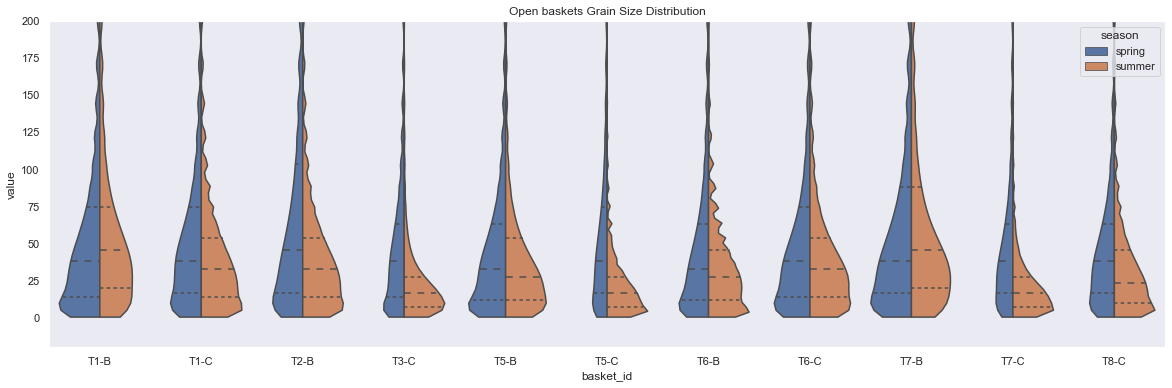

In [8]:
plt.figure(figsize=(20, 6))
# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=open_samples, x="basket_id", y="value", hue="season",
                    split=True, inner="quart", fill=False, cut=0)
ax.set_ylim(-20, 200)
ax.set_title('Open baskets Grain Size Distribution')
plt.savefig('violin_plot_open.png')
plt.show()

## Bonus - Testing Stuff

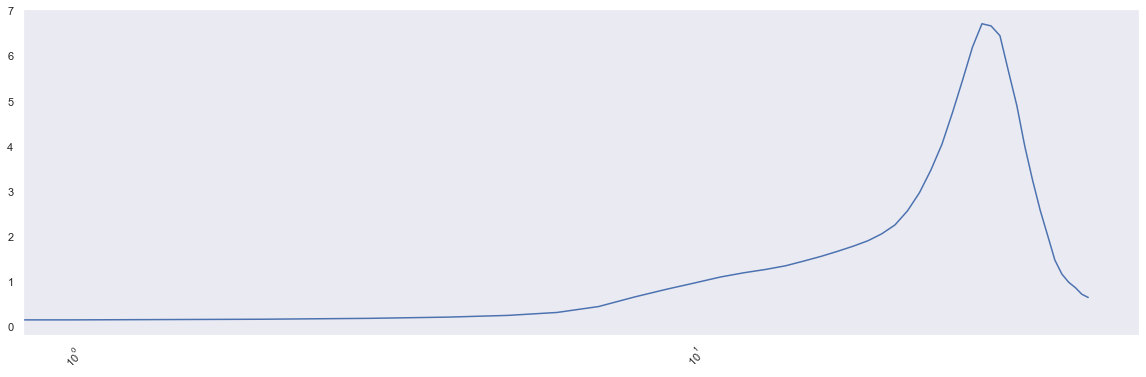

In [9]:
plt.figure(figsize=(20, 6))
plt.plot(spring['Size'][:-2], spring['T1-A'][:-2], label='T1-A')
plt.xticks(rotation=45)
plt.xscale('log')
plt.show()

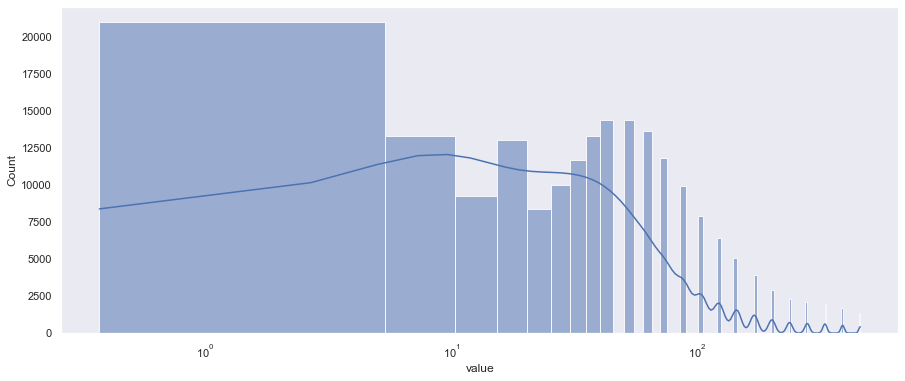

In [11]:
T1A = samples[samples['basket_id'] == 'T1-A']
plt.figure(figsize=(15, 6))
ax = sns.histplot(data=T1A, x="value", binwidth=5, kde=True)
ax.set_xscale('log')

esta weá está re mala

In [13]:
# load your data
df = spring.copy()

# convert 'Size (um)' column to numeric
sizes = pd.to_numeric(df.iloc[:-2, 0].values, errors='coerce')
percentages = df.iloc[:-2, 1].astype(float).values

num_samples = 10000000 # number of random samples to generate

# Generate the samples
random_samples = np.random.choice(sizes, size=num_samples, p=percentages/percentages.sum())

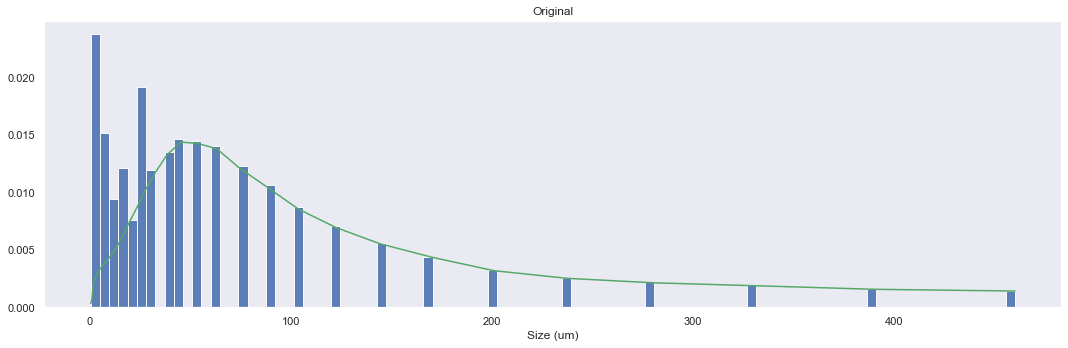

In [80]:
fig, axs = plt.subplots(figsize=(15, 5))

# original data
bin_width = np.diff(sizes).mean()  # approximate bin width
plt.hist(sizes, weights=percentages, bins=100, alpha=0.9, label='Original', color='b', density=True)
plt.plot(sizes, percentages/5000 * bin_width, color='g')  # line plot
plt.title('Original')
plt.xlabel('Size (um)')

plt.tight_layout()
plt.show()

In [36]:
test = pd.DataFrame({'size': sizes, 'percentage': percentages})
test['count'] = round(test['percentage'] * 1000)
# define a regular grid of grain sizes
regular_sizes = np.linspace(sizes.min(), sizes.max(), 8000)
regular = pd.DataFrame({'size': regular_sizes})
# interpolate percentages onto the regular grid
interp_func = interp1d(test['size'], test['count'], kind='linear')
regular_count = interp_func(regular_sizes)
# add the interpolated percentages to the df
regular['count'] = regular_count.round()
regular['percentage'] = regular['count'] / regular['count'].sum() * 100

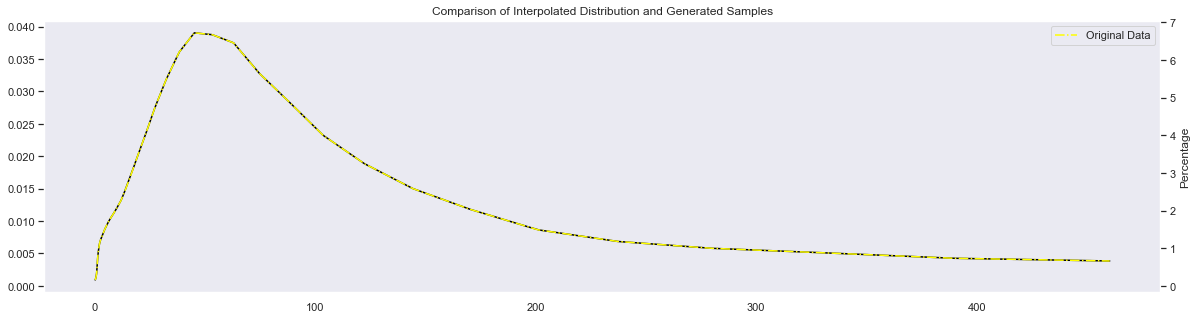

In [46]:
# plotting the interpolated distribution
plt.figure(figsize=(20, 5))
plt.plot(regular['size'], regular['percentage'], color='black', label='Interpolated Distribution')
# create a separate y axis
plt.twinx()
# plotting the original data
plt.plot(test['size'], test['percentage'], color='yellow', label='Original Data', linestyle='-.')

# Adding labels and title
plt.xlabel('Grain Size')
plt.ylabel('Percentage')
plt.title('Comparison of Interpolated Distribution and Generated Samples')
plt.legend()

# Show plot
plt.show()

I CREATED EQUALLY SIZED BINS!!!!!!!!!!!

In [48]:
# create a sample of 1000 points based off the binned interpolated distribution
num_points = 1000
repeated_values = np.repeat(test['size'], test['count'])
regular_values = np.repeat(regular['size'], regular['count'])

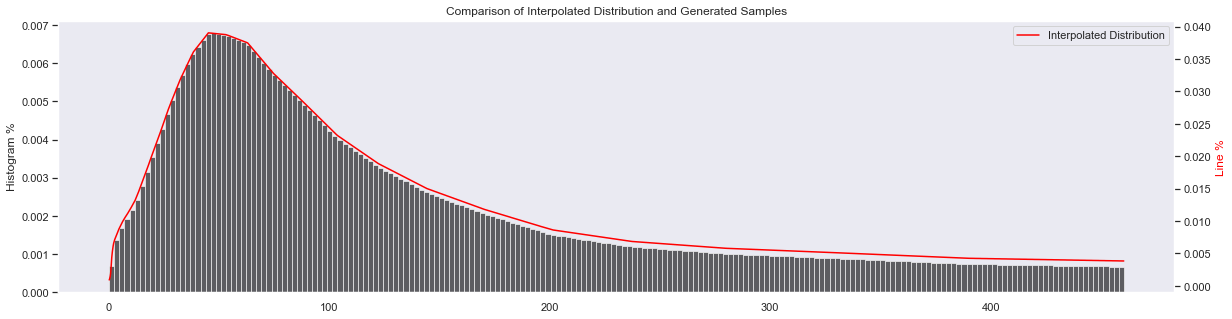

In [69]:
# plotting the interpolated distribution
plt.figure(figsize=(20, 5))
plt.hist(regular_values, bins=200, alpha=0.6, label='Interpolated Distribution', color='black', density=True)
plt.ylabel('Histogram %')
plt.twinx()
plt.plot(regular['size'], regular['percentage'], color='red', label='Interpolated Distribution')

plt.ylabel('Line %', color='red')
plt.xlabel('Grain Size')
plt.title('Comparison of Interpolated Distribution and Generated Samples')
plt.legend()

plt.show()

In [70]:
sum(regular['percentage'])

99.99999999999983

In [ ]:
sum()